<font size="+3"><strong>Polish Bankruptcy Prediction 🇵🇱 </strong></font>

<font size="+2"><strong>Part 3: Random Forest</strong></font>

In [8]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

So far in the `Working with JSON files` and `Imbalanced Data` projects, I've learned how to retrieve and decompress data, and how to manage imbalanced data to build a decision-tree model.

In this project, I'm going to expand my decision tree model into an entire forest (an example of **ensemble model**); use a **grid search** to tune hyperparameters; and create a function that loads data and a pre-trained model, and use that model to generate a Series of predictions.

In [9]:
import gzip
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

GOALS
 - Improve my bankruptcy model using random forest.
 - Evaluate model generalizability using cross validation.
 - Tune my model hyperparameters using grid search.
 - Build a prediction function that uses my saved model.

Machine Learning Workflow
 - Prepare Data
     - Import
     - Explore
     - Split
        - Resample: Over-sampling
 - Build Model
     - Baseline
     - Iterate
         - Random forest, cross validation, grid search
     - Evaluate 
         - Confusion matrix 
 - Communicate Results
     - Feature importances
     - Save model as file
     - Build predictions function 

# Prepare Data

As always, I'll begin by importing the dataset.

I'll extract the cross-validation resu

I'll write the `wrangle` function using the code I developed in the `Working with JSON files` project. Then I'll use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.

In [10]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    
    return df

In [11]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Split

In [12]:
# Create my feature matrix X and target vector y
target = "bankrupt"            # My target is "bankrupt"
feature = "feat_27"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


Since I'm not working with time series data, I'm going to randomly divide my dataset into training and test sets.

In [13]:
# Divide my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42             #  My test set should be 20% of my total data & set a random_state for reproducibility
)  

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


Here, I didn't create a validation set, even though I'm planning on tuning my model's hyperparameters in project. That's because I'm going to use cross-validation, which I'll talk about more later on.

## Resample

**Over-Sampling**

In [14]:
# Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

Now that I have my data set up the right way, I can build the model. 🏗

## Baseline

In [15]:
# Calculate the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

So far, I've built single models that predict a single outcome. That's definitely a useful way to predict the future, but what if the one model I built isn't the *right* one? If I could somehow use more than one model simultaneously, I'd have a more trustworthy prediction.

**Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. Since I used a decision tree in the `Imbalanced Data` project, I'm going to create an ensemble of trees here. This type of model is called a **random forest**.

I'll start by creating a pipeline to streamline my workflow.

**Random Forest**

In [16]:
# Create a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a RandomForestClassifier predictor
clf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=42))
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


By default, the number of trees in my forest (`n_estimators`) is set to 100. That means when I train this classifier, I'll be fitting 100 trees. While it will take longer to train, it will hopefully lead to better performance.

In order to get the best performance from my model, I need to tune its hyperparameter. But how can I do this if we haven't created a validation set? The answer is **cross-validation**. So, before I look at hyperparameters, I'll see how cross-validation works with the classifier I just built.

**Cross-Validation**

I'll perform cross-validation with my classifier, using the over-sampled training data. I want five folds, so I'll set `cv` to 5. I also want to speed up training, to I'll set `n_jobs` to -1.

In [17]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99670944 0.99835472 0.99769661 0.9970385  0.99901251]


That took kind of a long time because I just trained 500 random forest classifiers (100 jobs x 5 folds).

Now that I have an idea of how cross-validation works, I'll tune my model. The first step is creating a range of hyperparameters that I want to evaluate. 

**Parameter Grid**

I'll create a dictionary with the range of hyperparameters that I want to evaluate for my classifier. 

1. For the `SimpleImputer`, I'll try both the `"mean"` and `"median"` strategies. 
2. For the `RandomForestClassifier`, I'll try `max_depth` settings between 10 and 50, by steps of 10. 
3. Also for the `RandomForestClassifier`, I'll try `n_estimators` settings between 25 and 100 by steps of 25.

In [18]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

Now that I have my hyperparameter grid, I'll incorporate it into a **grid search**.

**Grid Search**

I'll create a `GridSearchCV` named `model` that includes my classifier and hyperparameter grid. I'll use the same arguments for `cv` and `n_jobs` that I used above, and set `verbose` to 1. 

In [19]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Finally, now I'll fit the model.

**Fit Model**

I'll fit `model` to the over-sampled training data.

In [20]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

This took some time to train, so I'll take a moment to think about why. 

How many forests did I just test? 4 different `max_depth`s times 3 `n_estimator`s times 2 imputation strategies... that makes 24 forests. How many fits did I just do? 24 forests times 5 folds is 120. And remember that each forest is comprised of 25-75 trees, which works out to *at least* 3,000 trees. So it's computationally expensive! 

Okay, now that I've tested all those models, I'll take a look at the results.

**Grid Search CV Results**

In [21]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.003555,0.038568,0.014670,0.008621,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,1.078364,0.035406,0.012074,0.001718,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,1.943403,0.051859,0.024954,0.007376,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,20
3,1.984070,0.045743,0.021914,0.006559,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,2.776293,0.079095,0.029498,0.003900,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.984534,0.984529,0.982164,0.002996,19
5,2.905376,0.064053,0.030062,0.006157,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980915,0.972688,0.981573,0.979928,0.981567,0.979334,0.003377,22
6,1.078525,0.025606,0.014092,0.002094,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996380,0.997038,0.995722,0.995393,0.997367,0.996380,0.000750,17
7,1.199057,0.039009,0.013357,0.004127,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995722,0.996709,0.997368,0.996380,0.998025,0.996841,0.000795,14
8,2.209300,0.015998,0.021985,0.002867,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996709,0.996709,0.995722,0.995064,0.997367,0.996314,0.000816,18
9,2.411177,0.112402,0.025450,0.006599,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996051,0.997368,0.998026,0.996709,0.998354,0.997302,0.000843,11


I'll extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.

In [22]:
type(model.cv_results_)

dict

In [23]:
model.cv_results_

{'mean_fit_time': array([1.00355539, 1.07836399, 1.94340334, 1.98407006, 2.77629285,
        2.90537648, 1.07852516, 1.19905667, 2.20930009, 2.41117682,
        3.42673826, 3.29229503, 1.08620858, 1.15216389, 2.10699034,
        2.23801274, 3.15159402, 3.28632994, 1.06176701, 1.17954669,
        2.14178104, 2.41711006, 3.24803786, 2.77838759]),
 'std_fit_time': array([0.03856819, 0.03540615, 0.05185897, 0.04574253, 0.07909457,
        0.06405301, 0.02560595, 0.0390085 , 0.01599794, 0.11240178,
        0.0487337 , 0.08662619, 0.02143532, 0.02709878, 0.06299303,
        0.04703319, 0.0371392 , 0.04001555, 0.00673546, 0.01877013,
        0.07555698, 0.04551205, 0.10208889, 0.31279351]),
 'mean_score_time': array([0.01466966, 0.01207418, 0.02495403, 0.02191372, 0.02949762,
        0.03006196, 0.0140924 , 0.01335678, 0.02198453, 0.02545037,
        0.03338242, 0.02829528, 0.01157928, 0.01366849, 0.02265434,
        0.02950273, 0.0344842 , 0.04188023, 0.01282077, 0.01302428,
        0.025758

In [24]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.003555,0.038568,0.014670,0.008621,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,1.078364,0.035406,0.012074,0.001718,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,1.943403,0.051859,0.024954,0.007376,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,20
3,1.984070,0.045743,0.021914,0.006559,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,2.776293,0.079095,0.029498,0.003900,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.984534,0.984529,0.982164,0.002996,19
5,2.905376,0.064053,0.030062,0.006157,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980915,0.972688,0.981573,0.979928,0.981567,0.979334,0.003377,22
6,1.078525,0.025606,0.014092,0.002094,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996380,0.997038,0.995722,0.995393,0.997367,0.996380,0.000750,17
7,1.199057,0.039009,0.013357,0.004127,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995722,0.996709,0.997368,0.996380,0.998025,0.996841,0.000795,14
8,2.209300,0.015998,0.021985,0.002867,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996709,0.996709,0.995722,0.995064,0.997367,0.996314,0.000816,18
9,2.411177,0.112402,0.025450,0.006599,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996051,0.997368,0.998026,0.996709,0.998354,0.997302,0.000843,11


In addition to the accuracy scores for all the different models I tried during my grid search, I can see how long it took each model to train. I'll take a closer look at how different hyperparameter settings affect training time. 

First, I'll look at `n_estimators`. My grid search evaluated this hyperparameter for various `max_depth` settings, but I'll only look at models where `max_depth` equals 10.

**Training Time vs N Estimators**

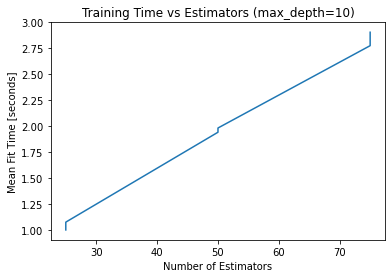

In [25]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

I'll create a mask for `cv_results` for rows where `"param_randomforestclassifier__max_depth"` equals 10. Then plot `"param_randomforestclassifier__n_estimators"` on the x-axis and `"mean_fit_time"` on the y-axis. 

In [26]:
cv_results["param_randomforestclassifier__max_depth"] == 10

0      True
1      True
2      True
3      True
4      True
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
Name: param_randomforestclassifier__max_depth, dtype: bool

In [27]:
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
cv_results[mask]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.003555,0.038568,0.014670,0.008621,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,1.078364,0.035406,0.012074,0.001718,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,1.943403,0.051859,0.024954,0.007376,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,20
3,1.984070,0.045743,0.021914,0.006559,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,2.776293,0.079095,0.029498,0.003900,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.984534,0.984529,0.982164,0.002996,19
5,2.905376,0.064053,0.030062,0.006157,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980915,0.972688,0.981573,0.979928,0.981567,0.979334,0.003377,22


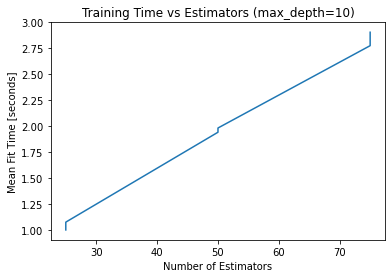

In [28]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

Next, I'll look at `max_depth`. Here, I'll also limit my data to rows where `n_estimators` equals 25.

**Training Time vs Max Depth**

I'll create a mask for `cv_results` for rows where `"param_randomforestclassifier__n_estimators"` equals 25. Then plot `"param_randomforestclassifier__max_depth"` on the x-axis and `"mean_fit_time"` on the y-axis. 

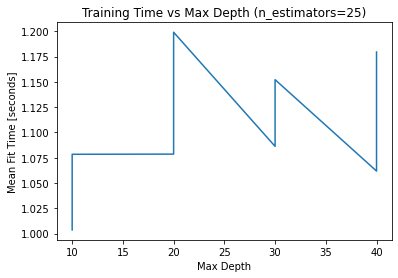

In [29]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25

# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]

)

# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

In [30]:
cv_results[mask]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.003555,0.038568,0.014670,0.008621,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,1.078364,0.035406,0.012074,0.001718,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
6,1.078525,0.025606,0.014092,0.002094,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996380,0.997038,0.995722,0.995393,0.997367,0.996380,0.000750,17
7,1.199057,0.039009,0.013357,0.004127,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995722,0.996709,0.997368,0.996380,0.998025,0.996841,0.000795,14
12,1.086209,0.021435,0.011579,0.001857,30,25,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.996380,0.997038,0.997368,0.995064,0.998025,0.996775,0.001007,15
13,1.152164,0.027099,0.013668,0.002114,30,25,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.996380,0.996709,0.999013,0.996380,0.999013,0.997499,0.001242,8
18,1.061767,0.006735,0.012821,0.002086,40,25,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996380,0.996709,0.997368,0.995064,0.998025,0.996709,0.000998,16
19,1.179547,0.018770,0.013024,0.001783,40,25,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996380,0.997697,0.998684,0.996709,0.999013,0.997697,0.001040,6


In [31]:
cv_results[mask][["mean_fit_time", "param_randomforestclassifier__max_depth", "param_simpleimputer__strategy"]]

,mean_fit_time,param_randomforestclassifier__max_depth,param_simpleimputer__strategy
0,1.003555,10,mean
1,1.078364,10,median
6,1.078525,20,mean
7,1.199057,20,median
12,1.086209,30,mean
13,1.152164,30,median
18,1.061767,40,mean
19,1.179547,40,median


There's a general upwards trend, but I see a lot of up-and-down here. That's because for each max depth, grid search tries two different imputation strategies: mean and median. Median is a lot faster to calculate, so that speeds up training time. 

Finally, I'll look at the hyperparameters that led to the best performance. 

**Extract Best Hyperparameters**

I'll extract the best hyperparameters from `model`.

In [32]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'median'}

In [33]:
model.best_score_

0.9978939791055105

In [34]:
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=50,
                                        random_state=42))])

In [35]:
model.predict(X_train_over)

array([False, False, False, ...,  True,  True,  True])

Note that I don't need to build and train a new model with these settings. Now that the grid search is complete, when I use `model.predict()`, it will serve up predictions using the best model.

## Evaluate

All right: The moment of truth. I'll see how my model performs.

In [36]:
# Calculate the training and test accuracy scores for model
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9589


I beat the baseline! Just barely, but I beat it. 

Next, I'm going to use a confusion matrix to see how my model performs. To better understand the values I'll see in the matrix, I'll first count how many observations in my test set belong to the positive and negative classes. 

In [37]:
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

**Confusion Matrix**

I'll plot a confusion matrix that shows how my best model performs on my test set. 

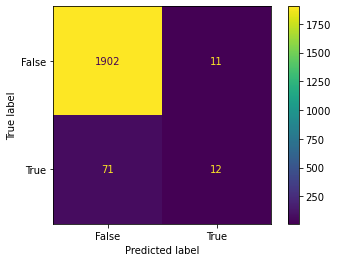

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Notice the relationship between the numbers in this matrix with the count I did the previous task. If I sum the values in the bottom row, I get the total number of positive observations in `y_train` ($72 + 11 = 83$). And the top row sum to the number of negative observations ($1902 + 11 = 1913$).

# Communicate

**Extract Feature Importances**

I'll create a horizontal bar chart with the 10 most important features for my model.

In [39]:
features = X_train_over.columns
features

Index(['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7',
       'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13',
       'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19',
       'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25',
       'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31',
       'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36', 'feat_37',
       'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42', 'feat_43',
       'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49',
       'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55',
       'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60', 'feat_61',
       'feat_62', 'feat_63', 'feat_64'],
      dtype='object')

In [40]:
importances = model.best_estimator_.named_steps[
    "randomforestclassifier"
].feature_importances_
importances

array([0.0101393 , 0.01287852, 0.01147172, 0.00905564, 0.02058596,
       0.02059257, 0.01113304, 0.01431152, 0.01338085, 0.0104422 ,
       0.00933864, 0.01591063, 0.0350984 , 0.00983862, 0.01471214,
       0.02722643, 0.00894526, 0.01105401, 0.01444032, 0.01044288,
       0.01948826, 0.01151105, 0.0140539 , 0.05165966, 0.01758254,
       0.02942304, 0.07060223, 0.0111041 , 0.01661098, 0.01036807,
       0.0133371 , 0.00643053, 0.00744856, 0.02801246, 0.02282155,
       0.00994131, 0.01103002, 0.02258117, 0.02095925, 0.01482569,
       0.01687734, 0.01275205, 0.00923591, 0.01261843, 0.01882168,
       0.03347121, 0.01110962, 0.01235876, 0.01284221, 0.00787817,
       0.01095399, 0.00680687, 0.00824845, 0.01027538, 0.01405089,
       0.01526372, 0.00959164, 0.02134601, 0.00752884, 0.01034815,
       0.00942581, 0.00831442, 0.00730218, 0.01178816])

In [41]:
feat_imp = pd.Series(importances, index=features)
feat_imp

feat_1     0.010139
feat_2     0.012879
feat_3     0.011472
feat_4     0.009056
feat_5     0.020586
             ...   
feat_60    0.010348
feat_61    0.009426
feat_62    0.008314
feat_63    0.007302
feat_64    0.011788
Length: 64, dtype: float64

In [42]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

feat_32    0.006431
feat_52    0.006807
feat_63    0.007302
feat_33    0.007449
feat_59    0.007529
             ...   
feat_26    0.029423
feat_46    0.033471
feat_13    0.035098
feat_24    0.051660
feat_27    0.070602
Length: 64, dtype: float64

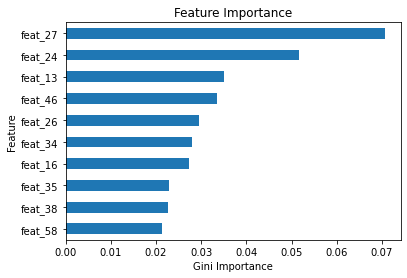

In [43]:
# Get feature names from training data
features = X_train_over.columns

# Extract importances from model
importances = model.best_estimator_.named_steps[
    "randomforestclassifier"
].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

The only thing left now is to save my model so that it can be reused.

**Save Model**

Using a context manager, I'll save my best-performing model to a a file named `"model-5-3.pkl"`. 

In [44]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)

**"Make Predictions" Function**

I'll create a function `make_predictions`. It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model. The function should load and clean the data using the `wrangle` function I created, load the model, generate an array of predictions, and convert that array into a Series. (The Series should have the name `"bankrupt"` and the same index labels as the test data.) Finally, the function should return its predictions as a Series. 

In [45]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

In [47]:
# Check my make_predictions function
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34    False
36    False
40    False
Name: bankrupt, dtype: bool